# Better Masking & Pasting

### Face Detection and Landmarks

In [9]:
import cv2
import helpers

import numpy as np
import mediapipe as mp

from matplotlib import pyplot as plt

In [10]:
det = helpers.model_processor(padding=0)

In [11]:
det.gen_face_route_index()

In [12]:
image = cv2.imread(r'E:\YAVU\Test_data\Inputs\ts2.png')
det.detect_for_image(image)

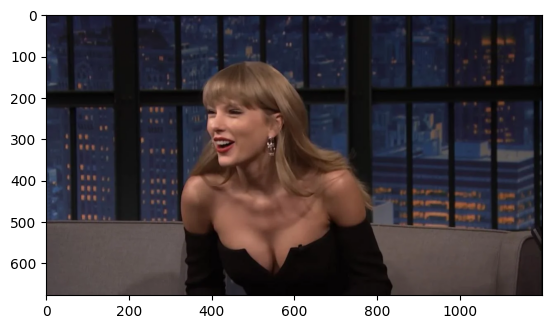

In [13]:
plt.imshow(image[:,:,::-1])

In [14]:
image.shape

(678, 1200, 3)

### MASK CREATION

In [15]:
dimensions = helpers.FrameDimensions()
dimensions.height, dimensions.width, _ = image.shape
helper = helpers.FaceHelpers(image_mode=True, dimensions=dimensions)

In [16]:
landmarks = np.load(r'E:\YAVU\temp\npy_files\image_landmarks.npy')

In [17]:
landmarks = landmarks*[image.shape[1], image.shape[0]]

In [18]:
landmarks = landmarks.reshape(486, 1, 2).astype(np.int32)
outline = cv2.convexHull(landmarks[:468], clockwise=True, returnPoints=True)

In [19]:
bbox = cv2.boundingRect(outline)

In [20]:
center = (bbox[0] + bbox[2]//2, bbox[1] + bbox[3]//2)

In [21]:
center

(466, 270)

In [22]:
mask = np.zeros(image.shape[:2], dtype=np.uint8)
mask = cv2.fillConvexPoly(mask, outline, 255)

inv_mask = cv2.bitwise_not(mask)

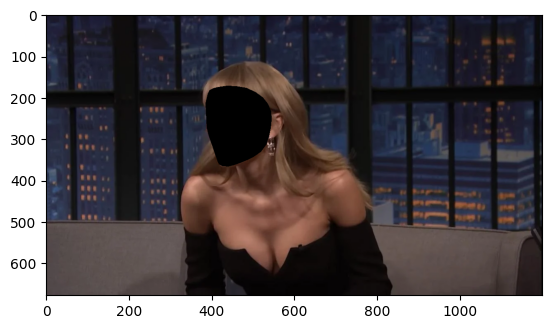

In [23]:
background = cv2.bitwise_and(image, image, mask=inv_mask)
plt.imshow(background[:,:,::-1])

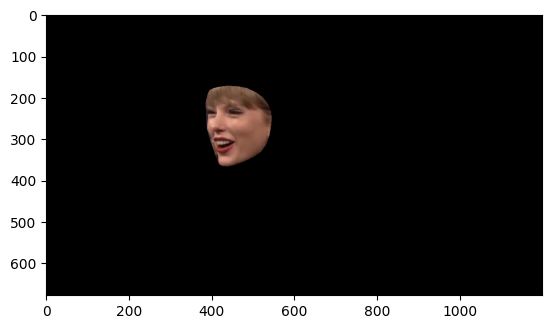

In [24]:
face = cv2.bitwise_and(image, image, mask=mask)
plt.imshow(face[:,:,::-1])

##### ALIGNMENT

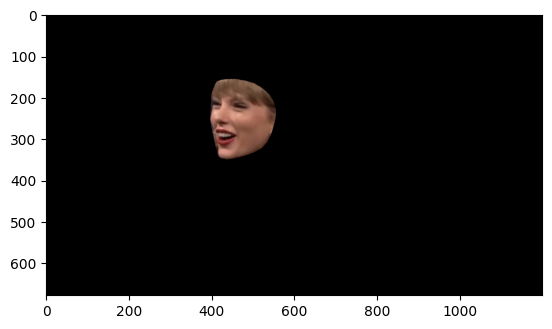

In [25]:
ext_image = face.copy()
aligned, aff_mat = helper.alignment_procedure(ext_image)
plt.imshow(aligned[:,:,::-1])

In [26]:
aligned_grey = cv2.cvtColor(aligned.copy(), cv2.COLOR_BGR2GRAY)
# Threshold the image to separate white and black pixels
threshold = 1  # Adjust this value as needed based on image lighting
ret, binary_image = cv2.threshold(aligned_grey, threshold, 255, cv2.THRESH_BINARY)

# Find contours of white objects
contours, hierarchy = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Assuming there's only one white ball (adjust logic if needed)
if len(contours) > 0:
    # Find the largest contour (likely the ball)
    largest_contour = max(contours, key=cv2.contourArea)

    # Calculate the bounding rectangle
    aligned_bbox = cv2.boundingRect(largest_contour)

    x, y, w, h = aligned_bbox


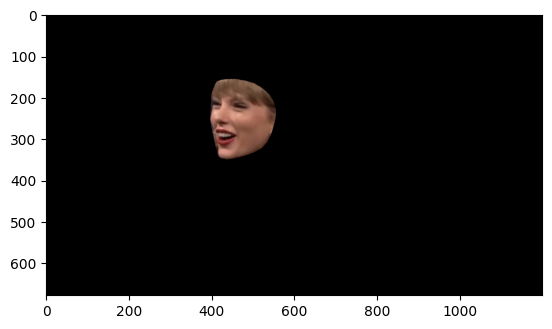

In [27]:
plt.imshow(aligned[:,:,::-1])

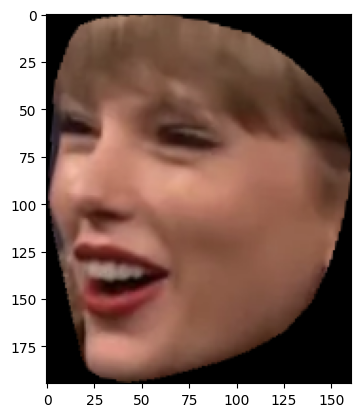

In [28]:
cropped_face = aligned[aligned_bbox[1]:aligned_bbox[1]+aligned_bbox[3], aligned_bbox[0]:aligned_bbox[0]+aligned_bbox[2]]
plt.imshow(cropped_face[:,:,::-1])

In [29]:
original_shape = cropped_face.shape

In [30]:
import model_loaders
ml = model_loaders.model_loaders('GFPGAN', 0.5)
restored = ml.restore_wGFPGAN(cropped_face)

Load GFPGAN checkpoint from: e:\YAVU\weights\gfpgan\GFPGANv1.4.pth


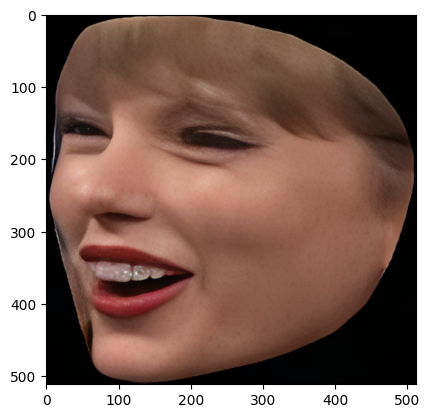

In [31]:
plt.imshow(restored[:,:,::-1])

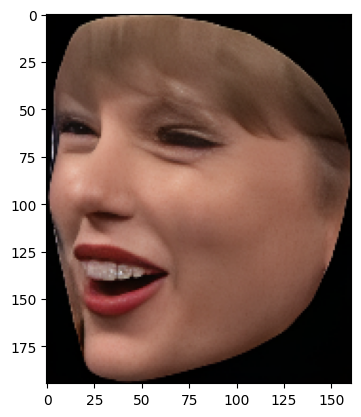

In [32]:
res_crop = cv2.resize(restored, (original_shape[1], original_shape[0]), interpolation=cv2.INTER_LANCZOS4)
# mask = cv2.resize(mask, (original_shape[1], original_shape[0]))
plt.imshow(res_crop[:,:,::-1])

In [33]:
aligned_bbox = np.asarray(([aligned_bbox[0], aligned_bbox[1]], [aligned_bbox[0]+aligned_bbox[2], aligned_bbox[1]+aligned_bbox[3]]))

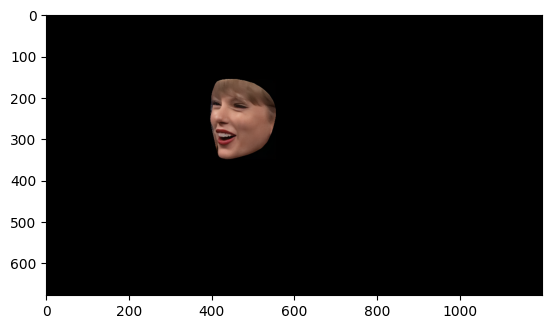

In [34]:
img = helper.paste_back_black_bg(res_crop, aligned_bbox, image)
plt.imshow(img[:,:,::-1])

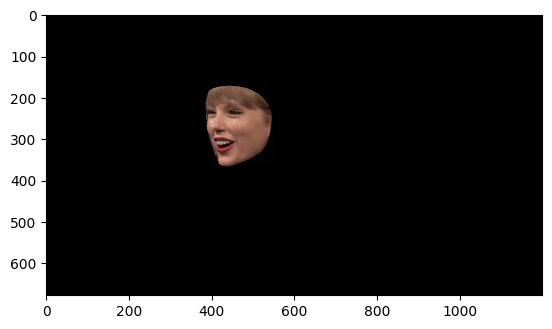

In [35]:
img = helper.unwarp_align(img, aff_mat)
plt.imshow(img[:,:,::-1])

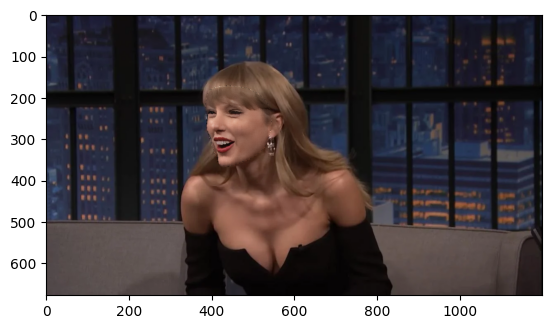

In [36]:
result = cv2.add(background, img)
plt.imshow(result[:,:,::-1])

In [37]:
# final = inv_soft_mask * pasted_face + (1 - inv_soft_mask) * image
# final = (inv_soft_mask.astype(np.uint8)*255) * pasted_face + (1 - (inv_soft_mask.astype(np.uint8)*255)) * image
# final = cv2.seamlessClone(pasted_face, image, inv_soft_mask.astype(np.uint8)*255, center.astype(np.int16)-[100, 100], cv2.NORMAL_CLONE)
final = cv2.seamlessClone(result, image, mask, center, cv2.MIXED_CLONE)

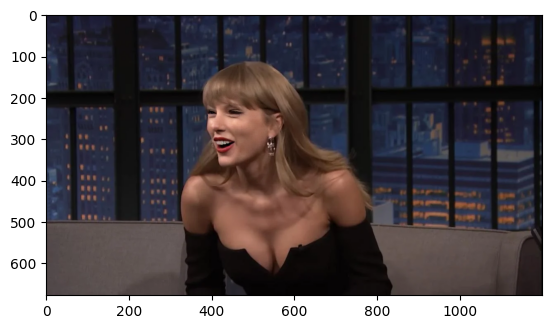

In [38]:
plt.imshow(final[:,:,::-1])

In [39]:
cv2.imwrite(r'E:\YAVU\temp\final.png', final)

True

In [40]:
# upsc = ml.restore_background(final, 1)

In [41]:
# plt.imshow(upsc[0][:,:,::-1])

In [1]:
import file_check
fc = file_check.FileCheck('RealESRGAN_x4plus')

path = fc.CODEFORMERS_MODEL_PATH
print(path)

e:\YAVU\.venv\lib\site-packages\torchvision\transforms\functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(


e:\YAVU\weights\codeformers\codeformer.pth
